<center><b>©Content is made available under the CC-BY-NC-ND 4.0 license. Christian Lopez, lopezbec@lafayette.edu<center>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/lopezbec/intro_python_notebooks/blob/master/LogRegression_Regularized_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
         </table>
          <br><br></br> 

## Logistic Regression Implementation



 This Notebook will give you an introduction to Logistic Regression
<br>

Most of the notebooks we are going to be using are inspired from existing notebooks that are available online and are made  free for educational purposes. The work of [Andre Ng]( https://en.wikipedia.org/wiki/Andrew_Ng)  and others served as guide and  inspiration for these notebooks. Nonetheless, these notebooks should not be share without prior permission of the instructor. When working in an assignment always remember the [Student Code of Conduct]( https://conduct.lafayette.edu/student-handbook/student-code-of-conduct/).  
</br>


## 1-Introduction

In this exercise, you will implement Logistic Regression and apply it to two different datasets. All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [ ]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

#To check how long our implementation takes
import time

!wget https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/Data_LogR/ex2data1.txt
!wget https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/Data_LogR/ex2data2.txt
np.random.seed(123)

--2023-02-07 21:02:11--  https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/Data_LogR/ex2data1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3775 (3.7K) [text/plain]
Saving to: ‘ex2data1.txt’

ex2data1.txt        100%[===================>]   3.69K  --.-KB/s    in 0s      

2023-02-07 21:02:12 (26.2 MB/s) - ‘ex2data1.txt’ saved [3775/3775]

--2023-02-07 21:02:12--  https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/Data_LogR/ex2data2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2

Lets load our data

In [ ]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

data = loaddata('ex2data1.txt', ',')

# The first two columns contains the exam scores and the third column
# contains the label.
X = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]]

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


### 1.1 Visualizing the data



Before starting to implement any learning algorithm, it is always good to visualize the data if possible. We  display the data on a 2-dimensional plot by calling the function `plotData`. You will now complete the code in `plotData` so that it displays a figure where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

To help you get more familiar with plotting, we have left `plotData` empty so you can try to implement it yourself. However, this is an optional (ungraded) exercise. We also provide our implementation below so you can
copy it or refer to it. If you choose to copy our example, make sure you learn
what each of its commands is doing by consulting the `matplotlib` and `numpy` documentation.


In [ ]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

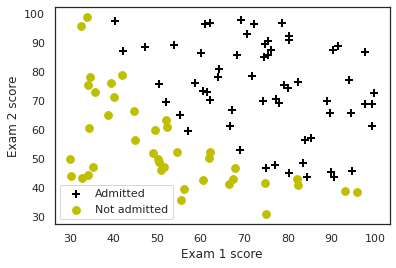

In [ ]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

<a id="section1"></a>
## 2 Implementation



### 2.1 Sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**
<a id="sigmoid"></a>

In [ ]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)

    ###======= START CODE HERE========== ### (≈ 1 lines of code)

    ###========= END CODE HERE=========== ###
    return g

The following cell evaluates the sigmoid function at `z=0`. You should get a value of 0.5. You can also try different values for `z` to experiment with the sigmoid function.

In [ ]:
sigmoid(0)

0.5

Scipy actually has a convenience function which does exactly the same:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

In [ ]:
from scipy.special import expit, logit

expit([0])


array([0.5])

`logit` is the inverse of `expit`:

In [ ]:
logit(expit([0]))

array([0.])

<a id="section2"></a>
### 2.2 Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. 

Now, complete the code for the function `costFunction` to return the cost. Recall that the cost function in logistic regression is

 $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$

Vectorized Cost Function
$$ J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

In [ ]:
def costFunction(theta, X, y):
    """
    Compute cost  for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    ###======= START CODE HERE========== ### (≈ 2 lines of code)


    ###========= END CODE HERE=========== ###             
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

Now, complete the code for the function `gradient` to return the gradient. Recall that the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$


Vectorized Gradient

 $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.
<a id="costFunction"></a>

In [ ]:
def gradient(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    
    grad : array_like
        A vector of shape (n+1,1) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    m = y.size
    ###======= START CODE HERE========== ### (≈ 2 lines of code)


    ###========= END CODE HERE=========== ###    

    return(grad.flatten())


In [ ]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

cost = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('\n')

grad = gradient(initial_theta, X, y)

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost = costFunction(test_theta, X, y)
grad = gradient(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))



Cost at initial theta (zeros): 0.693


Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]


Cost at test theta: 0.218


Gradient at test theta:
	[0.043, 2.566, 2.647]


**Expected Output (approx)**: 

```
Cost at initial theta (zeros): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
```


### 2.3 General Batch Gradient Descent

In this part, you will create a Batch Graident Descent algoriths that can work for multiple models (e.g., Logistic and Linear Regression)


Recall that in batch gradient descent, each iteration performs the update


$$ \theta_j = \theta_j - \alpha (\frac{\partial J(\theta)}{\partial \theta_j})$$

$$ \qquad \text{simultaneously update } \theta_j \text{ for j}=\{1,2,...n\} $$ 


With each step of gradient descent, your parameters come closer to the optimal values that will achieve the lowest cost J($\theta$).

<br>

Next, you will complete a function which implements General Batch Gradient Descent. The starter code for the function `General_Batch_GD` calls `costFunction` and `gradient` on every iteration and saves the cost to a `python` list. Assuming you have implemented all the functions correctly, your value of $J(\theta)$ should never increase, and should converge to a steady value by the end of the algorithm.
<br><br>




In [ ]:
def General_Batch_GD(X, y, theta, alpha, num_iters, costFunction,gradient):
    """
    Performs a vectorized gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : arra_like
        Value at given features. A vector of shape (m x 1 ).
    
    theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1 x 1).
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1 x 1 ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient.
    """
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions!!!
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration 
    ###======= START CODE HERE========== ### (≈ 2 lines of code)



    ###========= END CODE HERE=========== ### 
        # save the cost J in every iteration
        J_history.append(costFunction(theta, X, y))         
    return theta, J_history

Now lets test out General Gradient Descent Implementation

Time to run:7.618ms
Cost at theta found by optimize.minimize: 0.203
Theta:
	[1.718, 3.992, 3.726]


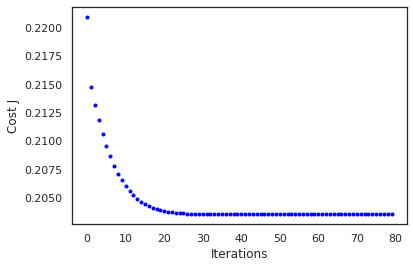

In [ ]:
# Lets try our code with T=1000
initial_theta = np.zeros(X.shape[1])


tic = time.process_time()
iterations = 80
alpha = 21

#Lets scale using StandardScaler() to undertand how it workd 
std_scaler = StandardScaler()
#Dont Scale the bias term
X_norm_nobias=std_scaler.fit_transform(data[:,0:2])
#Now add the bias
X_norm = np.c_[np.ones((data.shape[0],1)),X_norm_nobias]
theta_GD, J_history = General_Batch_GD(X_norm, y, initial_theta, alpha, iterations, costFunction,gradient)
cost_GD=costFunction(theta_GD, X_norm, y)

toc = time.process_time()

print("Time to run:"+str( round((1000*(toc - tic)),3)) + "ms")
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost_GD))


print('Theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta_GD))


# theta for minimized cost J
plt.plot(J_history, "b.")
# #plt.xlim(xmin=0.0)
plt.ylabel('Cost J')
plt.xlabel('Iterations');

**Expected Output (approx)**: 

```
Cost at theta found by optimize.minimize: 0.203

Expected theta (approx):
	[1.718, 3.993, 3.725]

```

Congratulations, you implemented Logistics Regression with Batch Gradient Descent!!....??

### 2.4 Learning parameters using `scipy.optimize`



In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `costFunction`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the [Jacobian (gradient)](https://www.value-at-risk.net/functions/) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [ ]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

#More about the BFGC algorithm:
#https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm


#While the the "TNC" method (as well as others) has a default scale funciton
#Lets scale using StandardScaler() to undertand how it workd 
std_scaler = StandardScaler()
#Dont Scale the bias term
X_norm_nobias=std_scaler.fit_transform(data[:,0:2])

#Keep your scale values for the future (predictions)
mu_sklearn=std_scaler.fit(X).mean_
sigma_sklearn=np.sqrt(std_scaler.fit(X).var_)

#Now add the bias
X_norm = np.c_[np.ones((data.shape[0],1)),X_norm_nobias]


tic = time.process_time()
res = minimize(costFunction, initial_theta, args=(X_norm,y), method="BFGS", jac=gradient, options=options)
toc = time.process_time()

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost__scipy = res.fun

# the optimized theta is in the x property
theta_scipy = res.x

# Print theta to screen
print("Time to run:"+str( round((1000*(toc - tic)),3)) + "ms")
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost__scipy))
print('\n');
print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta_scipy))


Time to run:7.264ms
Cost at theta found by optimize.minimize: 0.203


theta:
	[1.718, 3.993, 3.725]


**Expected Output (approx)**: 

```
Expected cost (approx): 0.203

Expected theta (approx):
	[1.718, 3.993, 3.725]

```

<a id="section4"></a>
### 2.5 Evaluating logistic regression



After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776. 
<a id="predict"></a>

In [ ]:
# Student with Exam 1 score 45 and Exam 2 score 85
new_student=np.array([1, 45, 85]).reshape(1,3)
#Scale data using same values
new_student_scale= (new_student-mu_sklearn)/sigma_sklearn

#YOU DONT WANT TO SCALE THE BIAS TERM
new_student_scale[0,0]=1

# Predict using the optimized Theta values from above (res.x)
prob_new_student=sigmoid(new_student_scale.dot(theta_scipy.reshape(-1,1)))
print(round(prob_new_student[0,0],4))

0.7762


In [ ]:
new_student_scale

array([[ 1.        , -1.06629865,  1.0155961 ]])

Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 

In [ ]:
def predict(theta, X, threshold=0.5):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 

    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples
    p = np.zeros(m)
    ###======= START CODE HERE========== ### (≈ 1 lines of code)


    ###========= END CODE HERE=========== ###
    
    return(p.astype('int'))

In [ ]:


print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob_new_student[0,0]))
print('\n')

# Compute accuracy on our training set
p = predict(theta_scipy, X_norm).reshape(-1,1)
#p=sigmoid(X_norm.dot(theta_scipy.reshape(-1,1)))>=0.5
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))


For a student with scores 45 and 85,we predict an admission probability of 0.776


Train Accuracy: 89.00 %


**Expected Output (approx)**: 

```
Expected value: 0.776

Expected accuracy (approx): 89.00 %

```

### 2.6 Decision boundary

Once `optimize.minimize` completes, we want to use the final value for $\theta$ to visualize the decision boundary on the training data as shown in the figure below. 


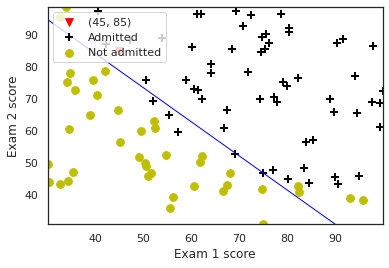

In [ ]:
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), 
                  (xx1.ravel()-mu_sklearn[1])/sigma_sklearn[1], 
                   (xx2.ravel()-mu_sklearn[1])/sigma_sklearn[1]].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

## 3 Regularized logistic regression



In this part, you will implement Regularized Logistic Regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.



In [ ]:
data2 = loaddata('ex2data2.txt', ',')

Dimensions:  (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [ ]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

### 3.1 Visualize the data

Similar to the previous parts of this exercise, `plotData` is used to generate a figure, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

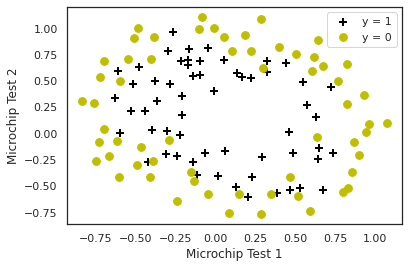

In [ ]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.




### 3.2 Feature mapping

One way to fit the data better is to create more features from each data point, by using the function `PolynomialFeatures` 

In [ ]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6, include_bias =True)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

(118, 28)

<a id="section5"></a>
### 3.3 Cost function Regularized Logistic Regression

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

Note that you should not regularize the parameters $\theta_0$. 

In [ ]:
def costFunctionReg(theta, reg,X, y):
    """
    Compute cost  for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    

    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    """
    m = y.size

    ###======= START CODE HERE========== ### (≈ 2 lines of code)  



    ###======= END CODE HERE========== ### 
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

<a id="section5"></a>
### 3.3 Gradient of Regularized Logistic Regression

 The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [ ]:
def gradientReg(theta, reg, X,y):
    """
    Compute the gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    """
    m = y.size
    ###======= START CODE HERE========== ### (≈ 2 lines of code)



    ###======= END CODE HERE========== ### 
       
    return(grad.flatten())

Once you are done with the `costFunctionReg`  and `gradientReg`, we call it below using the initial value of $\theta$ (initialized to all zeros), and also another test case where $\theta$ is all ones.

In [ ]:
# Initialize fitting parameters
initial_theta = np.zeros((XX.shape[1],1))

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost_Reg = costFunctionReg(initial_theta,lambda_, XX, y)
grad_Reg = gradientReg(initial_theta,lambda_, XX, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost_Reg[0]))
print('\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad_Reg))
print('\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones((XX.shape[1],1))
cost_Reg = costFunctionReg(test_theta,lambda_, XX, y)
grad_Reg = gradientReg(test_theta,lambda_, XX, y)


print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost_Reg[0]))
print('\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad_Reg))


Cost at initial theta (zeros): 0.693


Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]


------------------------------

Cost at test theta    : 2.13


Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.0851, 0.1185, 0.1506, 0.0159]


**Expected Output (approx)**: 

```
Cost at initial theta (zeros): 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 2.13

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.0851, 0.1185, 0.1506, 0.0159]
```

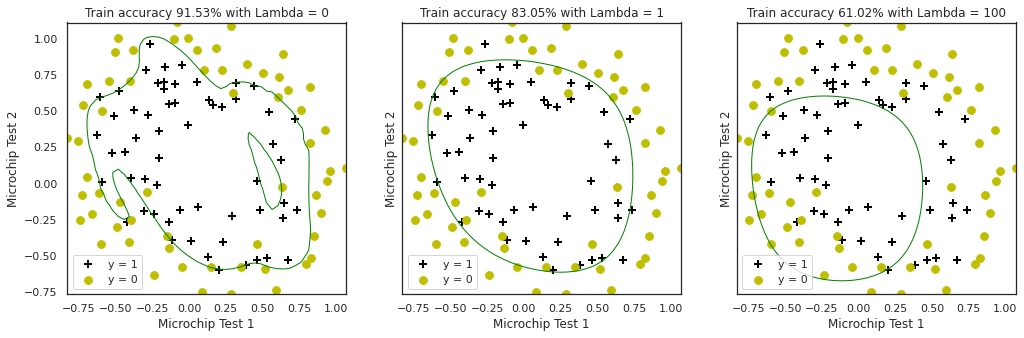

In [ ]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method="BFGS", jac=gradientReg, options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))

###### **DO NOT DELETE NOR MODIFY THESE CODE CELLS**




In [ ]:
# # ###DO NOT DELETE NOR MODIFY THIS CODE CELL####
!wget https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/GRADING_LogR.py
from GRADING_LogR import GRADING_LogR

try:
    sigmoid
except:
    sigmoid=None
try:
    cost
except:
    cost=None
try:
    grad
except:
    grad=None
try:
    theta_GD
except:
    theta_GD=None
try:
    cost_GD
except:
    cost_GD=None
try:
    prob_new_student
except:
    prob_new_student=None
try:
    cost_Reg
except:
    cost_Reg=None
try:
    grad_Reg
except:
    grad_Reg=None


GRADING_LogR(sigmoid,cost,grad,theta_GD,cost_GD,prob_new_student,cost_Reg,grad_Reg)

--2023-02-07 21:02:23--  https://raw.githubusercontent.com/lopezbec/intro_python_notebooks/main/GRADING_LogR.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224 (1.2K) [text/plain]
Saving to: ‘GRADING_LogR.py’

GRADING_LogR.py     100%[===================>]   1.20K  --.-KB/s    in 0s      

2023-02-07 21:02:23 (41.5 MB/s) - ‘GRADING_LogR.py’ saved [1224/1224]

sigmoid : True
cost : True
grad : True
theta_GD : True
cost_GD : True
predict : True
cost_Reg : True
grad_Reg : True
